In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [10]:
# Set global random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dataset
file_path = "STTHK3013_pilot_performance_simulation_data.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [11]:
# Handle missing values using median imputation
df.fillna(df.median(), inplace=True)

# Feature Engineering: Add Interaction and Polynomial Features
df['reaction_stress_interaction'] = df['time_reaction'] * df['environmental_stressors']
df['fatigue_mission_ratio'] = df['fatigue_level'] / (df['mission_complexity'] + 1)
df['heart_rate_squared'] = df['heart_rate'] ** 2

# Remove the used current features to avoid multicollinearity
df.drop(columns=['time_reaction', 'environmental_stressors', 'fatigue_level', 'mission_complexity', 'heart_rate'], inplace=True)

# Reclassify 'final_performance' into three categories
def classify_performance(value):
    if value in [0, 1]:
        return 0  # Basic
    elif value in [2, 3]:
        return 1  # Skilled
    else:
        return 2  # Expert

df['final_performance'] = df['final_performance'].apply(classify_performance)



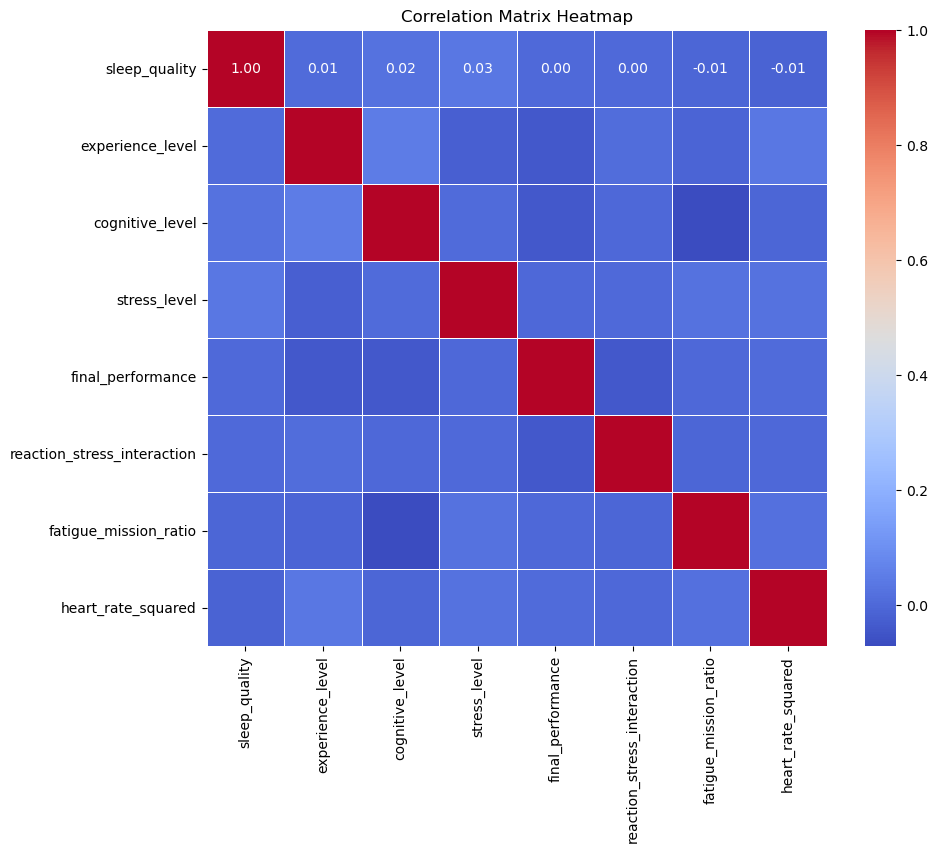

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [13]:
# Use the cleaned data (data_cleaned) for Chi-Square test
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from scipy import stats

X = df.drop(columns=['final_performance'])  # Correct column name
y = df['final_performance']  # Correct column name

# Remove Outliers using Z-score
z_scores = np.abs(stats.zscore(X))
X_filtered = X[(z_scores < 3).all(axis=1)]
y_filtered = y[X_filtered.index]

# Scale the feature data to be non-negative (using MinMaxScaler)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Apply Chi-Square Test for feature selection
chi2_selector = SelectKBest(chi2, k='all')  # Select all features
X_chi2 = chi2_selector.fit_transform(X_scaled, y_filtered)

# Get the Chi-Square p-values for each feature
p_values = chi2_selector.pvalues_

# Create a DataFrame to sort the features by p-values
p_values_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Square p-value': p_values
})

# Sort the features by p-value (ascending order)
p_values_df_sorted = p_values_df.sort_values(by='Chi-Square p-value', ascending=True)

# Print the sorted features by their Chi-Square p-value
print("\nFeatures sorted by Chi-Square p-values:\n")
print(p_values_df_sorted)



Features sorted by Chi-Square p-values:

                       Feature  Chi-Square p-value
1             experience_level            0.868891
2              cognitive_level            0.906813
6           heart_rate_squared            0.911556
4  reaction_stress_interaction            0.931239
5        fatigue_mission_ratio            0.993993
0                sleep_quality            0.995543
3                 stress_level            0.996990


In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Define the desired percentage increase (e.g., 90% increase → 1.9)
increase_percentage = 1.2  # Adjust this value as needed

# Subset the dataset with the selected features and target
selected_features = [
    'experience_level',
    'cognitive_level',
    'heart_rate_squared',
    'reaction_stress_interaction',
    'fatigue_mission_ratio' 
]
X = df[selected_features]
y = df['final_performance']  # Numerical target

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Calculate the new target class distribution
target_size_per_class = {cls: int(count * increase_percentage) for cls, count in Counter(y).items()}

# Apply SMOTE with the calculated target distribution
smote = SMOTE(sampling_strategy=target_size_per_class, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Display original and resampled data sizes
print(f"Original data size: {len(X)}")
print(f"Resampled data size: {len(X_resampled)}")
print(f"Percentage increase in data size: {((len(X_resampled) - len(X)) / len(X)) * 100:.2f}%")



Original class distribution: Counter({2: 358, 1: 324, 0: 297})
Class distribution after SMOTE: Counter({2: 429, 1: 388, 0: 356})
Original data size: 979
Resampled data size: 1173
Percentage increase in data size: 19.82%


In [15]:
# Train and Optimize Models with Stratified K-Fold CV
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "Deep Neural Network (MLP)": {
        'hidden_layer_sizes': [(256, 128, 64), (512, 256, 128)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.005]
    },
    "XGBoost": {
        'n_estimators': [300, 400, 500],
        'max_depth': [6, 9, 12],
        'learning_rate': [0.01, 0.05, 0.1]
    }
}

models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "Deep Neural Network (MLP)": MLPClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE)
}

best_models = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, param_grid in param_grids.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(models[name], param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Best Params for {name}: {grid_search.best_params_}")

# Split dataset for final testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE, stratify=y_resampled)

# Standardize features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train & Compare All Optimized Models
final_results = {}
for name, model in best_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=2)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    final_results[name] = {"accuracy": accuracy, "report": report, "confusion_matrix": conf_matrix}

    # Display results
    print(f"===== {name} =====")
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", conf_matrix, "\n")

# Identify the Best Performing Model
best_model_name = max(final_results, key=lambda x: final_results[x]['accuracy'])
best_model_params = best_models[best_model_name].get_params()

print(f"\nBest Model: {best_model_name} with Accuracy: {final_results[best_model_name]['accuracy']:.4f}")
print(f"Best Model Parameters: {best_model_params}")


Optimizing Logistic Regression...
Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Optimizing Deep Neural Network (MLP)...
Best Params for Deep Neural Network (MLP): {'activation': 'tanh', 'hidden_layer_sizes': (512, 256, 128), 'learning_rate_init': 0.005}
Optimizing XGBoost...


c:\Users\USER\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\USER\miniconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[00:22:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 300}
===== Logistic Regression =====
Accuracy: 0.3446808510638298

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.14      0.19        71
           1       0.35      0.28      0.31        78
           2       0.35      0.57      0.43        86

    accuracy                           0.34       235
   macro avg       0.34      0.33      0.31       235
weighted avg       0.34      0.34      0.32       235


Confusion Matrix:
 [[10 14 47]
 [11 22 45]
 [11 26 49]] 

===== Deep Neural Network (MLP) =====
Accuracy: 0.4851063829787234

Classific

c:\Users\USER\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


===== XGBoost =====
Accuracy: 0.40425531914893614

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.35      0.34        71
           1       0.40      0.42      0.41        78
           2       0.47      0.43      0.45        86

    accuracy                           0.40       235
   macro avg       0.40      0.40      0.40       235
weighted avg       0.41      0.40      0.41       235


Confusion Matrix:
 [[25 27 19]
 [23 33 22]
 [26 23 37]] 


Best Model: Deep Neural Network (MLP) with Accuracy: 0.4851
Best Model Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (512, 256, 128), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 

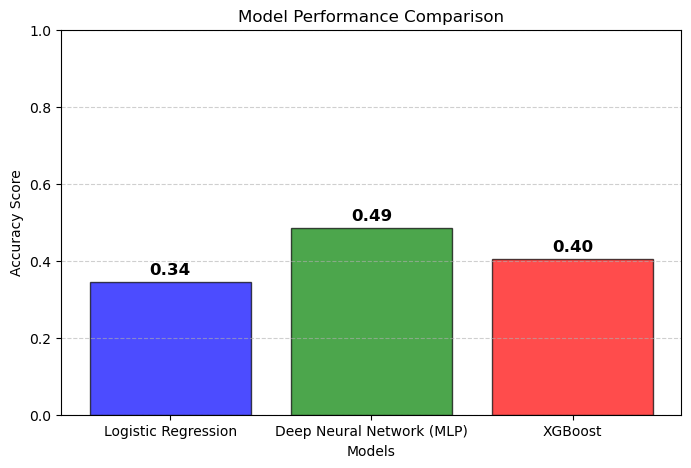

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and accuracy scores
data = {
    "Logistic Regression": final_results["Logistic Regression"]["accuracy"],
    "Deep Neural Network (MLP)": final_results["Deep Neural Network (MLP)"]["accuracy"],
    "XGBoost": final_results["XGBoost"]["accuracy"]
}

models = list(data.keys())
accuracies = list(data.values())

# Create a figure and axis
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black')

# Adding labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization

# Annotating the bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}", 
             ha='center', fontsize=12, fontweight='bold', color='black')

# Display the grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()
